## Reinforcement Learning

* The Reinforcement learning is characterized by an **agent** learning to interact with its **environment**.
* At each time step, the environment presents a situation to the agent called a **state**. The agent then has to choose an appropriate **action** in response.  
* One time step later, the agent receives a **reward**. A reward can be negative or positive. This is the environment's way of telling the agent whether it has responded with an appropriate action or not. The agent also receives a new state.

                    This is how the agent-environment interaction looks like:
![](images/reinforcement-agent.png "The Agent-Environment Interaction")

* Now, the main goal of the agent is to maximize expected **cumulative reward**. This simply means the expected sum of rewards attained over all the time steps.
* The reward hypothesis is that all goals for any agent are framed as the **maximization of the expected cumulative reward**.

At an arbitrary time step $t$, the agent-environment interaction is simply a bunch of states, actions and rewards like so:

$\bigl(S_0, A_0, R_1, S_1, A_1, R_2, ..., R_{t - 1}, S_{ t - 1}, A_ {t - 1}, R_t, S_t, A_t  \bigr)$







#### How do we implement Reinforcement Learning?
Enter Markov Decision Processes (MDP). We define our RL problem in the form of an MDP. MDPs provide a framework to model a decision making process for the agent.

But what are they, you ask? Simple: An MDP can be defined follows:
* A (finite) set of states S
* A (finite) set of actions A (The actions available to the agent)
* A (finite) set of rewards R (The reward the agent will get after transitioning from one state to another)
* The one-step dynamics of the environment and,
* A discount rate $\gamma$ (gamma) where $0\leq\gamma\leq1$.

Points to note:

The discount rate $\gamma$ represents the degree of importance between present and future rewards the agent gets. 

But why are we doing a discounted return in the first place? 

The main aim of doing this is to **refine the goal** you have for the agent. 

If $\gamma = 0$, the agent will only care about the immediate reward.

If $\gamma = 1$, then the return is not discounted. 

This means that the  $\gamma$ has to be close to 1. 

Should the present reward carry the same weight as future rewards? No. It actually makes more sense to value rewards that come sooner more highly since they are more predictable. The closer in time the reward is to the agent the more juicier it is to it!

Therefore, the larger the discount rate is, the larger the immediate reward.

$ G_t = \mathopen{} R_{t + 1} + \gamma R_{t + 2} + \gamma^2 R_{t + 3} + \text{... } $

If we replace the values for example, we can have it as:

$ G_t = \mathopen{} R_{t + 1} + (0.9) R_{t + 2} + (0.82) R_{t + 3} + \text{... } $

Moving on swiftly.

Now, you must be wondering what _the one-step dynamics of the environment_ is all about. 

Well, it's purpose is to help the environment decide the state and rewards the agent gets at every time step.

When the environment responds to the agent at time step $t+1$, **it considers only the state and action at the previous time step
$(S_t, A_t)$**. 

This means that it doesn't care or look at the actions, rewards or states **that came prior to the last time step**. This dictates the one-step dynamics of the environment. 

It is therefore a conditional probability ($P(A \mid B)$ –– meaning we find the probability that event A will happen given event B has already occured). The one-step dynamic of the environment is defined as follows:

$$ P(s', r \mid s, a) = P\bigl(S_{t+1} = s', R_{t + 1} = r \mid S_t = s, A_t = a) \text{ for each possible } s, r, s' \text { and } a $$


#### Solving MDPs
Now that we've learnt to define a problem into an MDP, how does the Agent decide which actions to take given its states?
This is where the **policy** comes in.  
The core problem is to come up with a policy that'll help the agent map the set of states to the set of actions it will take. 
A policy is simply a function $\pi$ that specifies the action **$\pi(s)$** the agent will choose when state **$s$**.

Therefore, in order to solve an MDP, the agent must determine the best policy. The best policy will be an optimal policy that tells the agent to select actions so that it always gets the highest possible cumulative reward.

There are two ways of defining a policy:
* Deterministic policy –– this is a mapping $ \pi:S \xrightarrow\ A $
* Stochastic policy –– this uses probability. For each state $s$ and action $a$, it creates a probability $\pi(a \mid s)$ that the agent chooses action $a$ while in state $s$
    $$ \pi(a \mid s) = \Pr\bigl(A_t = a \mid S_t = s) $$


#### How do we do this in code?
We can therefore use the stochastic policy on a neural network, where the network will return the probability that the agent should select each possible action.

We will incorporate the policy of the MPD as a neural network. The environment's state will be passed in as **input** and the output will be the probabilities of actions to be selected. 

For the agent to select an action, it chooses an action that has the highest probability. 

The reward is then given and the environment presents a new state to the agent.(For a game, the reward == score, the state = new level or updated screen with a different challenge or something)

First, the network will initialize the weights for the policy at random. It will learn to select the best weights eventually making the policy optimal.

#### Tools we need
* [OpenAI Gym](https://gym.openai.com/docs/) –– This library is a collection of test problems(environments) that you can use to develop and compare reinforcement learning algorithms. The environments come with a shared interface, which allows us to write general algorithms. Install it by running `pip install gym`
* [PyTorch](https://pytorch.org/) –– A deep learning framework for fast, flexible experimentation on Tensors and Dynamic neural networks in Python. Install it by running `pip install torch`
* [Matplotlib](https://matplotlib.org/) –– A Python 2D plotting library to be used for plotting


## Let the coding begin!
#### Step 1: Import packages 

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


####  Step 2: Initialize a random agent
It's important to initialize a random agent so that we can see how the agent behaves and observe the cumulative reward(measured as the score) we get when we run an episodal task. Let's go ahead and create a random agent and see how it behaves. 

Score: 13


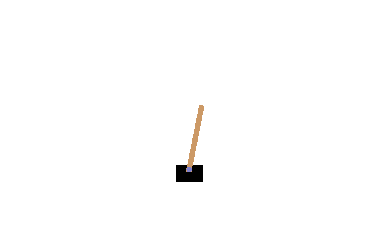

In [11]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t_episode in range(1000):
    action = env.action_space.sample()
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    
    if done:
        print('Score:', t_episode + 1)
        break
        
env.close()

#### Step 3: Define the Architecture of the Policy
We will define a neural network that encodes a stochastic policy.

The network that we'll define takes the  envrironment's **state as input** and returns the probability that the agent should select each possible action as the output. The output will be two numbers say [0.8, 0.2]. This means that the agent will pushe the pole to the ledt with 80% probability. Afte selecting this action, it sends the action to the environment and receives the next state and a reward.


When we initialize the NN, all weights are random. The goal of the agent is to figure out the appropriate weights in the NN, so that for each state, the NN always outputs probabilities that help the agent get a high score.


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("action space:", env.action_space)
print("observation space:", env.observation_space)

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        """
        Neural network that encodes the policy
        
        Params
        s_size(int): dimension of each state (size of input layer)
        h_size(int): size of hidden layer
        a_size(int): number of potential actions (size of output layer)
        """
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)
        
    def forward(self, x):
        # activation functions is ReLu (Rectified Linear unit)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
        

cpu
action space: Discrete(2)
observation space: Box(4,)


#### Step 4: Train the agent
We'll use the REINFORCE algorithm(Monte Carlo Policy Gradients) to help the agent train the weights of the neural network while it plays the game.

In [ ]:
env.seed(0)
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=200, gamma=1.0, print_every=100):
    """
    Pytorch impelementation of the REINFORCE algorithm
    
    Params
    n_episodes(int): maximum number of training episodes
    max_t(int): maximum number of timesteps per episode
    gamma(float): discount rate
    print_every (int): how often to print average score (over last 100 episodes)
    """
    scores_deque = deque(maxlen=100)
    scores = []
    for episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for i in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i  for i in range(len(rewards) + 1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
            
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if episode % print_every == 0:
            print('Episode {}\t Average Score:  {:.2f}'.format(episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes. \tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_deque)))
    
    return scores

scores = reinforce()

Episode 100	 Average Score:  22.18
Episode 200	 Average Score:  29.66
Episode 300	 Average Score:  68.12
Episode 400	 Average Score:  122.18
Episode 500	 Average Score:  177.55
Episode 600	 Average Score:  167.32


#### Step 5: Plot the Scores

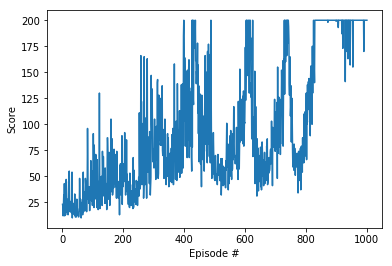

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Step 6: Watch the agent play
Finally, we'll watch the trained agent perform better on it's environment

Score:  147


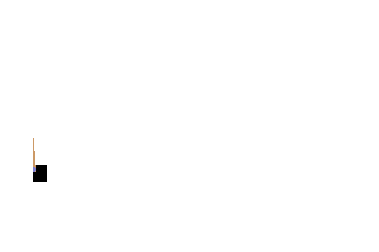

In [8]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action, _ = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        print('Score: ', t+1)
        break
        
env.close()